In [1]:
# pip install pyhealth

### STEP 1: load the chest Xray data

In [2]:
from pyhealth.datasets import COVID19CXRDataset

root = "/srv/local/data/COVID-19_Radiography_Dataset"
base_dataset = COVID19CXRDataset(root, refresh_cache=False)

base_dataset.stat()

/home/chaoqiy2/miniconda3/envs/moltext/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Statistics of COVID19CXRDataset:
Number of samples: 21165
Number of classes: 4
Class distribution: Counter({'Normal': 10192, 'Lung Opacity': 6012, 'COVID': 3616, 'Viral Pneumonia': 1345})


### STEP 2: set task and processing the data

In [3]:
from torchvision import transforms

sample_dataset = base_dataset.set_task()

# the transformation automatically normalize the pixel intensity into [0, 1]
transform = transforms.Compose([
    transforms.Lambda(lambda x: x if x.shape[0] == 3 else x.repeat(3, 1, 1)), # only use the first channel
    transforms.Resize((128, 128)),
])

def encode(sample):
    sample["path"] = transform(sample["path"])
    return sample

sample_dataset.set_transform(encode)

Generating samples for COVID19CXRClassification: 100%|███████████████████████████████████████████| 21165/21165 [00:00<00:00, 2783009.72it/s]


In [4]:
from pyhealth.datasets import split_by_visit, get_dataloader

# split dataset
train_dataset, val_dataset, test_dataset = split_by_visit(
    sample_dataset, [0.8, 0.1, 0.1]
)
train_dataloader = get_dataloader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = get_dataloader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = get_dataloader(test_dataset, batch_size=256, shuffle=False)

In [5]:
data = next(iter(train_dataloader))
print (data["path"][0].shape)

print(
    "loader size: train/val/test",
    len(train_dataset),
    len(val_dataset),
    len(test_dataset),
)

torch.Size([3, 128, 128])
loader size: train/val/test 16932 2116 2117


### STEP3: define the GAN model

In [18]:
from pyhealth.models import GAN

model = GAN(
    input_channel=3,
    input_size=128,
    hidden_dim = 256,
)

### STEP4: training the GAN model in an adversarial way

In [24]:
import torch
from tqdm import tqdm

# Loss function
loss = torch.nn.BCELoss()
opt_G = torch.optim.AdamW(model.generator.parameters(), lr=1e-3)
opt_D = torch.optim.AdamW(model.discriminator.parameters(), lr=1e-4)

device = "cuda:4"
model.to(device)

curve_D, curve_G = [], []

for epoch in range(50):
    curve_G.append(0)
    curve_D.append(0)
    for batch in tqdm(train_dataloader):
        
        """ train discriminator """
        opt_D.zero_grad()

        real_imgs = torch.stack(batch["path"], dim=0).to(device)
        batch_size = real_imgs.shape[0]
        fake_imgs = model.generate_fake(batch_size, device)
        
        real_loss = loss(model.discriminator(real_imgs), torch.ones(batch_size, 1).to(device))
        fake_loss = loss(model.discriminator(fake_imgs.detach()), torch.zeros(batch_size, 1).to(device))
        loss_D = (real_loss + fake_loss) / 2

        loss_D.backward()
        opt_D.step()
        
        """ train generator """
        opt_G.zero_grad()
        loss_G = loss(model.discriminator(fake_imgs), torch.ones(batch_size, 1).to(device))

        loss_G.backward()
        opt_G.step()
        
        curve_G[-1] += loss_G.item()
        curve_D[-1] += loss_D.item()

    print (f"epoch: {epoch} --- loss of G: {curve_G[-1]}, loss of D: {curve_D[-1]}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:56<00:00,  1.18it/s]


epoch: 0 --- loss of G: 235.46342170238495, loss of D: 38.44307478144765


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.15it/s]


epoch: 1 --- loss of G: 189.38715118169785, loss of D: 30.993362290784717


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.17it/s]


epoch: 2 --- loss of G: 239.08964610099792, loss of D: 6.970357734709978


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:54<00:00,  1.22it/s]


epoch: 3 --- loss of G: 282.8131763935089, loss of D: 4.137967556715012


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:55<00:00,  1.20it/s]


epoch: 4 --- loss of G: 255.01798963546753, loss of D: 5.110567823052406


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:54<00:00,  1.23it/s]


epoch: 5 --- loss of G: 304.87264013290405, loss of D: 8.64646109007299


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:52<00:00,  1.28it/s]


epoch: 6 --- loss of G: 500.5840277671814, loss of D: 24.204148830845952


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:56<00:00,  1.19it/s]


epoch: 7 --- loss of G: 451.33461332321167, loss of D: 0.7537129627307877


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:55<00:00,  1.21it/s]


epoch: 8 --- loss of G: 431.7444968223572, loss of D: 6.4659804629627615


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:56<00:00,  1.18it/s]


epoch: 9 --- loss of G: 596.1160368919373, loss of D: 7.6383128159234275


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.16it/s]


epoch: 10 --- loss of G: 484.0970947742462, loss of D: 15.179329166712705


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.16it/s]


epoch: 11 --- loss of G: 407.63574838638306, loss of D: 0.530137675232254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.16it/s]


epoch: 12 --- loss of G: 312.33895611763, loss of D: 3.4384627752006054


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.16it/s]


epoch: 13 --- loss of G: 312.2976408004761, loss of D: 2.7867361521348357


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.16it/s]


epoch: 14 --- loss of G: 264.729043006897, loss of D: 7.06029037386179


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.17it/s]


epoch: 15 --- loss of G: 225.16066551208496, loss of D: 11.562116228044033


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.16it/s]


epoch: 16 --- loss of G: 218.4423906803131, loss of D: 8.810364093631506


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.17it/s]


epoch: 17 --- loss of G: 312.99179339408875, loss of D: 11.620514743030071


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.16it/s]


epoch: 18 --- loss of G: 211.89375686645508, loss of D: 9.615357603877783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.17it/s]


epoch: 19 --- loss of G: 171.22825515270233, loss of D: 25.423519730567932


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:56<00:00,  1.18it/s]


epoch: 20 --- loss of G: 210.7448410987854, loss of D: 24.356860101222992


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.14it/s]


epoch: 21 --- loss of G: 244.63870346546173, loss of D: 11.02416418865323


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.15it/s]


epoch: 22 --- loss of G: 243.14930987358093, loss of D: 22.47604788094759


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.16it/s]


epoch: 23 --- loss of G: 274.94408202171326, loss of D: 26.34657647460699


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.15it/s]


epoch: 24 --- loss of G: 234.09665405750275, loss of D: 16.731902796775103


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.14it/s]


epoch: 25 --- loss of G: 306.30480122566223, loss of D: 16.174514853628352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.14it/s]


epoch: 26 --- loss of G: 330.1878414154053, loss of D: 34.08231335878372


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.14it/s]


epoch: 27 --- loss of G: 254.93080186843872, loss of D: 14.502326969988644


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.14it/s]


epoch: 28 --- loss of G: 276.89978194236755, loss of D: 17.942093975842


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.14it/s]


epoch: 29 --- loss of G: 207.1793919801712, loss of D: 22.071087922900915


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.16it/s]


epoch: 30 --- loss of G: 158.61903989315033, loss of D: 27.629727222025394


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.16it/s]


epoch: 31 --- loss of G: 202.9431939125061, loss of D: 25.77581850066781


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.14it/s]


epoch: 32 --- loss of G: 324.6885280609131, loss of D: 36.55593832582235


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.15it/s]


epoch: 33 --- loss of G: 221.39485549926758, loss of D: 11.331106215715408


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.16it/s]


epoch: 34 --- loss of G: 147.92780953645706, loss of D: 38.99323396384716


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.15it/s]


epoch: 35 --- loss of G: 192.14132618904114, loss of D: 28.10118254646659


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.15it/s]


epoch: 36 --- loss of G: 235.25207090377808, loss of D: 31.65054650232196


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.15it/s]


epoch: 37 --- loss of G: 157.7527117729187, loss of D: 31.56289905309677


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.13it/s]


epoch: 38 --- loss of G: 203.90822780132294, loss of D: 24.688751220703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.15it/s]


epoch: 39 --- loss of G: 193.7863022685051, loss of D: 27.719643944874406


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.16it/s]


epoch: 40 --- loss of G: 148.90731024742126, loss of D: 24.35784476995468


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.16it/s]


epoch: 41 --- loss of G: 138.36136281490326, loss of D: 32.37918431684375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.15it/s]


epoch: 42 --- loss of G: 144.17725467681885, loss of D: 24.131414487957954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:59<00:00,  1.14it/s]


epoch: 43 --- loss of G: 137.79231882095337, loss of D: 28.492403000593185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.15it/s]


epoch: 44 --- loss of G: 130.22422045469284, loss of D: 29.230164095759392


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.16it/s]


epoch: 45 --- loss of G: 178.59211683273315, loss of D: 18.080337017774582


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.15it/s]


epoch: 46 --- loss of G: 208.3746610879898, loss of D: 37.55503672361374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.15it/s]


epoch: 47 --- loss of G: 149.65763175487518, loss of D: 29.568245857954025


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:57<00:00,  1.17it/s]


epoch: 48 --- loss of G: 229.93753325939178, loss of D: 25.85401887446642


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:58<00:00,  1.15it/s]

epoch: 49 --- loss of G: 215.52084922790527, loss of D: 15.89515457302332


### EXP 2: synthesize random images

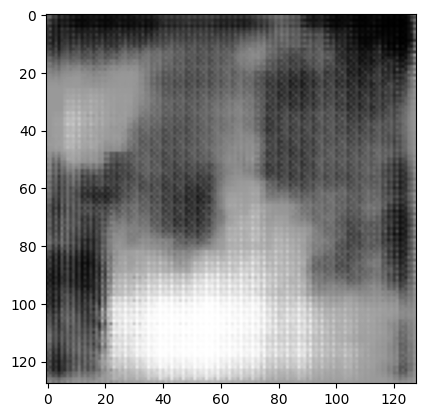

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    fake_imgs = model.generate_fake(1, device).detach().cpu()
    plt.imshow(fake_imgs[0][0], cmap="gray")
    plt.show()